In [1]:
import os
import json
import torch
import random
import Precisions
import torchvision
import pandas as pd
import torch.nn as nn
import numpy as np
from PIL import Image
import torch.optim as optim
from matplotlib import patches
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from torchvision.models import ResNet50_Weights, MobileNet_V3_Large_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn, FasterRCNN_MobileNet_V3_Large_FPN_Weights

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# from https://github.com/sgrvinod/Deep-Tutorials-for-PyTorch 
# in file datasets.py under MIT license
# this class allows me to get a new set of data without having to physically move the images and annotations
class PascalVOCDataset(Dataset):
    def __init__(self, data_folder, split):
        self.split = split.upper()
        assert self.split in {'TRAIN', 'TEST'}
        self.data_folder = data_folder

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)
        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        image = Image.open(self.images[i], mode='r')
        # making sure images are all same size so they can be stacked in collate
        image = image.convert('RGB')

        # setting values of targets to tensors
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  
        labels = torch.LongTensor(objects['labels']) 
        
        # resizing image and bbox
        width, height = image.width, image.height
        old_dims = torch.FloatTensor([width, height, width, height]).unsqueeze(0)
        new_boxes = boxes / old_dims * IMG_SIZE
        new_image = F.resize(image, (IMG_SIZE, IMG_SIZE))
        
        # dictionary of targets
        target = {}
        target['boxes'] = new_boxes
        target['labels'] = labels

        # transform to torch and normalize
        new_image = F.to_tensor(new_image)
        new_image = F.normalize(new_image, mean=mean, std=std)

        return new_image, target

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        images = list()
        targets = list()
        for b in batch:
            images.append(b[0])
            targets.append(b[1])
        images = torch.stack(images, dim=0)

        return images, targets

In [5]:
def plot_image(image, output, true_box, save=False, file=None):
    # converting input image back to regular
    image = image.cpu().numpy().transpose(1, 2, 0)
    image = image*np.array(std)+np.array(mean)
    image = np.clip(image, 0, 1)
    
    fig = plt.figure()
    ax = plt.Subplot(fig, 111)
    fig.add_subplot(ax)
    ax.imshow(image)
    
    bbox = output['boxes'].cpu().numpy()
    true_box = true_box.cpu().numpy()
    
    # converting to coco box
    bbox[:, 2] = bbox[:, 2] - bbox[:, 0]
    bbox[:, 3] = bbox[:, 3] - bbox[:, 1]
    
    for b in range(10):
        ax.add_patch(patches.Rectangle(
            (bbox[b][0], bbox[b][1]), bbox[b][2], bbox[b][3],
            linewidth=1, edgecolor='red', facecolor='none'))
    for box in true_box:
        box[2] = box[2] - box[0]
        box[3] = box[3] - box[1]
        ax.add_patch(patches.Rectangle(
                (box[0], box[1]), box[2], box[3],
                linewidth=1, edgecolor='green', facecolor='none'))
    ax.axis('off')
    if save:
        fig.savefig(file)

In [6]:
data_folder = 'F:/Det_Project/full_dataset'
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
num_classes = 6
batch_size = 6
IMG_SIZE = 112
num_boxes = 15

In [7]:
train_dataset = PascalVOCDataset(data_folder, split='train')
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=lambda x:list(zip(*x)))

In [8]:
backbone_weights = MobileNet_V3_Large_Weights.IMAGENET1K_V2
weights = FasterRCNN_MobileNet_V3_Large_FPN_Weights
model = fasterrcnn_mobilenet_v3_large_fpn(weights=weights, backbone_weights=backbone_weights, box_detections_per_img=num_boxes)

#weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
#weights = ResNet50_Weights.IMAGENET1K_V2
#model = fasterrcnn_resnet50_fpn(weights=weights, box_detections_per_img=num_boxes)

C:\Users\Belda\anaconda3\envs\ObjDet\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The following training setup is inspired by this tutorial:
> https://www.kaggle.com/code/bharatb964/pytorch-implementation-of-faster-r-cnn

In [9]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model=model.to(device)

In [10]:
reload_step = 0
n_epochs = 18
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01)

# Reloading for continual learning

In [9]:
### only for continuing training ###
reload_step = 2
model.load_state_dict(torch.load('models/model_{}.pth'.format(reload_step)))

<All keys matched successfully>

# Training

In [11]:
model.train()
total_losses = list()
for epoch in range(n_epochs):
    for X_batch, y_batch in train_loader:
        # making sure on device
        X_batch = list(X.to(device) for X in X_batch)
        y_batch = [{k: v.to(device) for k, v in t.items()} for t in y_batch]
        
        # getting prediction losses
        pred_loss = model(X_batch, y_batch)
        total_loss = sum(loss for loss in pred_loss.values())
        total_loss.backward()
        
        # stepping
        optimizer.zero_grad()
        optimizer.step()
    total_losses.append(total_loss.item())
    print('Epoch {}/{} complete, loss = {}'.format((epoch+1),n_epochs, total_loss.item()))

Epoch 1/18 complete, loss = 2.8878462314605713
Epoch 2/18 complete, loss = 3.348783254623413
Epoch 3/18 complete, loss = 2.9353489875793457
Epoch 4/18 complete, loss = 3.0882041454315186
Epoch 5/18 complete, loss = 2.9500725269317627
Epoch 6/18 complete, loss = 3.0402908325195312
Epoch 7/18 complete, loss = 3.5721962451934814
Epoch 8/18 complete, loss = 3.374530792236328
Epoch 9/18 complete, loss = 3.2781107425689697
Epoch 10/18 complete, loss = 3.5647995471954346
Epoch 11/18 complete, loss = 3.296774387359619
Epoch 12/18 complete, loss = 2.473008155822754
Epoch 13/18 complete, loss = 4.129650592803955
Epoch 14/18 complete, loss = 4.787254333496094
Epoch 15/18 complete, loss = 2.8078174591064453
Epoch 16/18 complete, loss = 3.510704278945923
Epoch 17/18 complete, loss = 3.090057373046875
Epoch 18/18 complete, loss = 3.128458023071289


# Saving

In [12]:
torch.save(model.state_dict(), 'models/mobilenet_{}epoch_SGD_lr_01_box15_both.pth'.format(n_epochs+reload_step))
torch.save(total_losses,'losses/mobilenet_losses_{}epoch_SGD_lr_01_box15_both.pth'.format(n_epochs+reload_step))

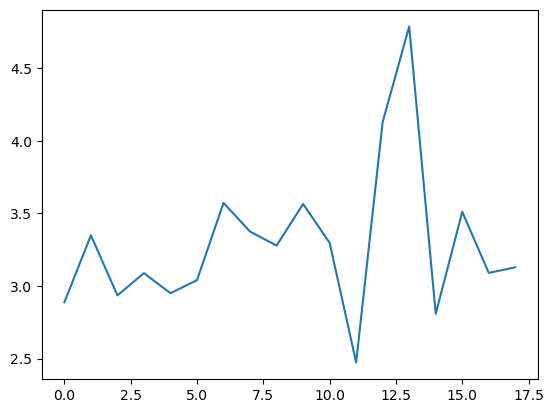

In [13]:
plt.plot(range(n_epochs), total_losses)

# Reloading for testing

In [10]:
reload_step = 18
model.load_state_dict(torch.load('models/model_{}epoch_SGD_lr_01_backbone.pth'.format(reload_step)))

<All keys matched successfully>

# Testing

In [14]:
number_test_images = 100
test_dataset = PascalVOCDataset(data_folder, split='test')
data_indices = np.arange(0,len(test_dataset))
random.shuffle(data_indices)
small_test_set = torch.utils.data.Subset(test_dataset, data_indices[:number_test_images])

In [15]:
test_batch = 6
test_loader = torch.utils.data.DataLoader(small_test_set, batch_size=test_batch, shuffle=True,
                                               collate_fn=lambda x:list(zip(*x)))

In [16]:
model.eval()
y_list = []
batch_index = 0

for X_batch, y_batch in test_loader:
    y_list.extend(y_batch)
    # making sure on device
    X_batch = list(X.to(device) for X in X_batch)
    y_batch = [{k: v.to(device) for k, v in t.items()} for t in y_batch]
        
    # getting bbox, label, score
    output = model(X_batch)
    torch.save(output,'batch_data/batch_{}.path'.format(batch_index))
    batch_index = batch_index+1


In [17]:
data = []
for i in range(batch_index):
    batch_temp = torch.load('batch_data/batch_{}.path'.format(i), map_location='cpu')
    data.extend(batch_temp)

In [18]:
with torch.no_grad():
    mAP, AP = Precisions.AP(data, y_list)

In [19]:
print('AP:\n',AP,'\n\nmAP:\n',mAP)
torch.save([mAP,AP], 'APs/AP_mobilenet_{}epoch_SGD_lr_01_box15.path'.format(reload_step))

AP:
 {'1': 0, '4': 0, '2': 0, '3': 0, '5': 0} 

mAP:
 0.0


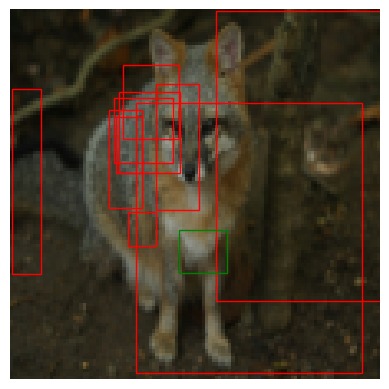

In [24]:
batch_index_from_last = 2
with torch.no_grad():
    plot_image(X_batch[batch_index_from_last], data[batch_index_from_last-1], y_batch[batch_index_from_last-1]['boxes'], save=False, file='images/mobilenet_18epoch_SGD_lr_01_box15_both_example.png')